In [1]:
!pip install Cython
!pip install brian2
from brian2 import *
%matplotlib inline
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
#np.set_printoptions(threshold='nan')


In [0]:
#Initialize random weights for the internal reservoir conncetion 
def initWeight(n, density, rho):
    W = scipy.sparse.random(n, n, density, data_rvs=np.random.randn)
    eigw, _ = scipy.sparse.linalg.eigs(W, 1)
    W /= np.abs(eigw[0])
    return W.toarray() * rho

In [0]:
#Random noise input to the two networks for training
runtime_train = 3*second
random_input = TimedArray(np.random.randn(int(runtime_train/(10*defaultclock.dt))),
                      dt=defaultclock.dt*10)


In [0]:
#Sine wave input for testing
runtime_test = 1*second
sine_input = TimedArray(np.hstack([sin(2*0.003*np.array(range(int(0.5*runtime_test/defaultclock.dt)))),
                                   np.zeros(int(0.5*runtime_test/defaultclock.dt))]),dt=defaultclock.dt)


In [5]:
#Set parameters of the continuous network
netSizeM = 500
lambda_x = 1
tau = 150*defaultclock.dt
freq = 10*Hz
density = 0.2
w_input = 0.5*np.random.randn(netSizeM)

esr=0
while (esr < 0.95 or esr > 1.0):
  W = initWeight(netSizeM, density, 1)

  #Check the effective spectral radius
  W_tilde = (defaultclock.dt/tau)*W+(1-lambda_x*defaultclock.dt/tau)*np.identity(netSizeM)
  print "delta/c:", defaultclock.dt/tau 
  eigw, _ = np.linalg.eig(W_tilde)
  esr = np.abs(eigw[0])
  print "The effective spectral radius:", esr

  
  
#Define a group of leaky integrator units
stimulus = sine_input
equX = '''dx/dt=(-lambda_x*x+0.41+y+w_in*stimulus(t))/tau : 1
          y = tanh(ysum) : 1
          s = stimulus(t) : 1
          ysum : 1
          w_in : 1 '''
units = NeuronGroup(netSizeM, model=equX)
#w_in is the input matrix 
units.w_in = w_input




#Connect the units by random weights
connectX = '''ysum_post = x_pre*w : 1 (summed)
              w : 1'''
SynX = Synapses(units, units, model=connectX)
SynX.connect()
SynX.w = W.flatten()


#Record variables of the network
unitM = StateMonitor(units, ('x', 'y', 's'), record=True)

delta/c: 0.00666666666667
The effective spectral radius: 0.9976972129831111


In [0]:
#Set parameters of the spiking network
netSizeN = netSizeM
lambda_v = lambda_x
lambda_s = lambda_v
res = 0
theta = 0.4


#Define a group of spiking neurons
equV = '''dv/dt=(-lambda_v*v+0*theta*(lambda_s-lambda_x)*r+0.41+switchy*y+switchz*z+w_in*stimulus(t))/tau : 1
          z : 1
          y = tanh(ysum) : 1
          ysum : 1
          dr/dt=(-lambda_s*r)/tau : 1
          w_in : 1 '''
resetV = '''v=res
            r+=1'''

neurons = NeuronGroup(netSizeN, model=equV, threshold='v > res+theta', reset=resetV, refractory=1*ms)
#w_in is the input matrix 
neurons.w_in = w_input


connectV = '''z_post = r_pre*w_syn : 1 (summed)
              w_syn : 1'''
#Connect the spiking neurons to themselves
SynV = Synapses(neurons, neurons, model=connectV)
SynV.connect()
SynV.w_syn = W.flatten()



neuronM = StateMonitor(neurons, ('v', 'y', 'r', 'z'), record=True)
spikeM = SpikeMonitor(neurons)

In [0]:
#Add connection from ESN to Spiking network
SynXV = Synapses(units, neurons, model=connectX)
SynXV.connect()
SynXV.w = W.flatten()


mixedRNN = Network([units, SynX, unitM, neurons, SynXV, neuronM, spikeM, SynV])

In [8]:
# Run the reservoir with randomly intialized weights
mixedRNN.store('t=0')
switchz=1
switchy=0
stimulus = sine_input
mixedRNN.run(runtime_test)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.84s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.19s). [brian2.stateupdaters.base.method_choice]


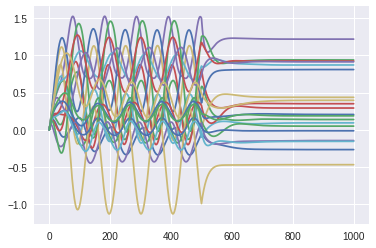

In [9]:
#Plot x
for i in range(20):
    plot(unitM.t/ms, unitM.x[i])

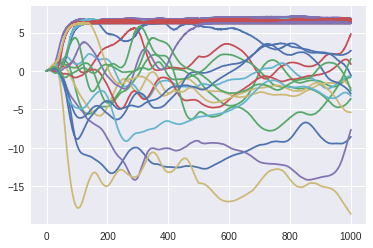

In [10]:
#Plot v + theta*r

for i in range(20):
    plot(neuronM.t/ms, neuronM.v[i]+theta*neuronM.r[i])

# Training

In [11]:
mixedRNN.restore('t=0')
stimulus = random_input
switchy = 1 
switchz = 0
mixedRNN.run(runtime_train)
#mixedRNN.store('train_t=1')


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.71s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]


In [0]:
r_mat = neuronM.r
y_mat = neuronM.y
s_mat = unitM.s
x_mat = unitM.x

In [0]:
#Train w_syn such that y=W_syn*r


alpha = 100
W_syn = np.linalg.inv(r_mat.dot(r_mat.T) + alpha * np.eye(netSizeN)).dot(r_mat).dot(y_mat.T).T

# Testing

In [0]:
#Run the simulation again, switch z on and y off
mixedRNN.restore('t=0')
SynV.w_syn = W_syn.T.flatten()
switchz=1
switchy=0
stimulus = sine_input
mixedRNN.run(runtime_test)
#mixedRNN.store('aftertrain_test_t=1')

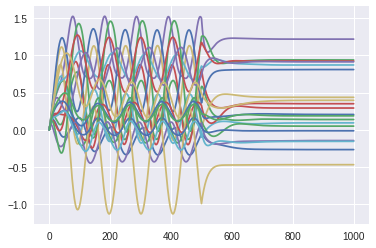

In [15]:
#Plot x
for i in range(20):
    plot(unitM.t/ms, unitM.x[i])

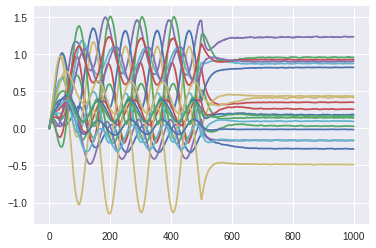

In [16]:
#Plot v + theta*r

for i in range(20):
    plot(neuronM.t/ms, neuronM.v[i]+theta*neuronM.r[i])